# Compare Genome vs Transcriptome for DMS samples: Madrasin + Controls

## Purpose
Aim of this script is to get the ratio of Genomic reads to Transcriptomic reads for samples that were treated with DMS 

We want to see how the ratio changes as you add varying concentrations of Madrasin

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [3]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [4]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [5]:
if feature=="Gene":
    fileToRead="quant.genes.sf"
else:
    fileToRead="quant.sf"

In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [7]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if (("transcripts_quant_genenames" in filename) and "transcripts_quant_genenames_" not in filename) and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus" in filename) or ("All_DMS" in filename)):
        print filename
        # Read the salmon output file
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Sort the data by TPM
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Mad-30mm-8hr-minus_S12_transcripts_quant_genenames
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames
Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames
All_DMSfiles_transcripts_quant_genenames
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames


In [8]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

68


In [9]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if (("transcripts_quant_genenames" in filename) and "transcripts_quant_genenames_" not in filename) and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus" in filename) or ("All_DMS" in filename)):
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

Mad-30mm-8hr-minus_S12_transcripts_quant_genenames
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames
Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames
All_DMSfiles_transcripts_quant_genenames
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames


In [10]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(68, 7)


,Mad-30mm-8hr-minus_S12,Mad-20mm-8hr-DMS_S8,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,All_DMSfiles,Mad-10mm-4hr-DMS_S1,Mad-30mm-4hr-DMS_S3
ACTB,1419.660,1418.540,1338.760,1617.670,1594.370,1784.850,1346.810
ATP5F1B,113.119,128.089,104.942,124.856,296.140,120.389,104.607
CDKN1A,137.488,150.867,542.708,148.800,258.294,327.403,106.975
CFL1,179.519,203.607,139.732,297.833,303.996,221.360,190.529
CORO1A,414.587,398.477,388.940,492.647,664.437,485.053,389.946


In [11]:
# Create a data frame with unique top features as column
feature_readCounts_genome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_genome.columns.values)
    if "transcripts_quant_genenames_AgainstGenomicCoordinates" in filename and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus" in filename) or ("All_DMS" in filename)):
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_genome = pd.concat([feature_readCounts_genome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_genome.columns = current_columns

Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames_AgainstGenomicCoordinates
All_DMSfiles_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-30mm-8hr-minus_S12_transcripts_quant_genenames_AgainstGenomicCoordinates


In [12]:
feature_readCounts_genome = feature_readCounts_genome.iloc[:,range(1,feature_readCounts_genome.shape[1])]
feature_readCounts_genome.index = sorted(unique_top_features)
print feature_readCounts_genome.shape
feature_readCounts_genome.head()

(68, 7)


,Mad-10mm-8hr-DMS_S7,Mad-30mm-4hr-DMS_S3,Mad-20mm-8hr-DMS_S8,All_DMSfiles,Mad-20mm-4hr-DMS_S2,Mad-10mm-4hr-DMS_S1,Mad-30mm-8hr-minus_S12
ACTB,788.4580,813.9420,860.0130,940.0810,1027.7000,1079.8700,897.6990
ATP5F1B,31.3488,33.2628,39.9411,93.4186,40.4189,37.7409,39.2728
CDKN1A,261.8940,53.0501,94.2313,132.5250,88.9728,160.6240,91.4921
CFL1,67.6090,87.6647,96.8718,150.5700,148.5620,105.6950,93.2004
CORO1A,172.0300,176.9820,178.1690,309.1120,231.2750,216.0120,206.0920


In [13]:
# Let's get ratios of feature counts for transcriptomic vs genomic
ratios_readCounts = (feature_readCounts_genome)/(feature_readCounts_transcriptome)
print ratios_readCounts.shape
ratios_readCounts.head()

(68, 7)


,All_DMSfiles,Mad-10mm-4hr-DMS_S1,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,Mad-20mm-8hr-DMS_S8,Mad-30mm-4hr-DMS_S3,Mad-30mm-8hr-minus_S12
ACTB,0.589625,0.605020,0.588946,0.635296,0.606266,0.604348,0.632334
ATP5F1B,0.315454,0.313491,0.298725,0.323724,0.311823,0.317979,0.347181
CDKN1A,0.513078,0.490600,0.482569,0.597935,0.624598,0.495911,0.665455
CFL1,0.495303,0.477480,0.483848,0.498810,0.475778,0.460112,0.519167
CORO1A,0.465224,0.445337,0.442305,0.469454,0.447125,0.453863,0.497102


In [14]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratios_readCounts.apply(np.median,axis=0)
ratios_readCounts_avg

All_DMSfiles              0.198987
Mad-10mm-4hr-DMS_S1       0.183698
Mad-10mm-8hr-DMS_S7       0.191198
Mad-20mm-4hr-DMS_S2       0.222599
Mad-20mm-8hr-DMS_S8       0.212846
Mad-30mm-4hr-DMS_S3       0.202833
Mad-30mm-8hr-minus_S12    0.209967
dtype: float64

/usr/local/lib/python2.7/dist-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


['', 'All_DMSfiles', 'Mad-10mm-4hr-DMS_S1', 'Mad-10mm-8hr-DMS_S7', 'Mad-20mm-4hr-DMS_S2', 'Mad-20mm-8hr-DMS_S8', 'Mad-30mm-4hr-DMS_S3', 'Mad-30mm-8hr-minus_S12']


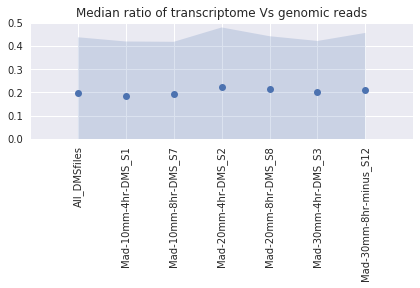

In [15]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.title("Median ratio of transcriptome Vs genomic reads")
plt.savefig("../results/MedianRatio_TranscriptomeVsGenomicReads_PlusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

['', 'All_DMSfiles', 'Mad-10mm-4hr-DMS_S1', 'Mad-10mm-8hr-DMS_S7', 'Mad-20mm-4hr-DMS_S2', 'Mad-20mm-8hr-DMS_S8', 'Mad-30mm-4hr-DMS_S3', 'Mad-30mm-8hr-minus_S12']


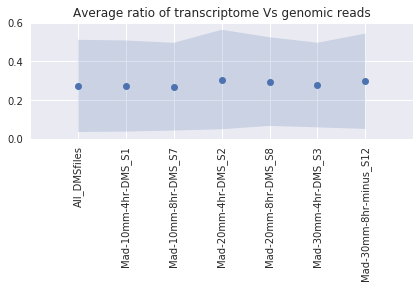

In [16]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
plt.ylim(0, 0.6)
plt.tight_layout()
plt.title("Average ratio of transcriptome Vs genomic reads")
plt.savefig("../results/MeanRatio_TranscriptomeVsGenomicReads_PlusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

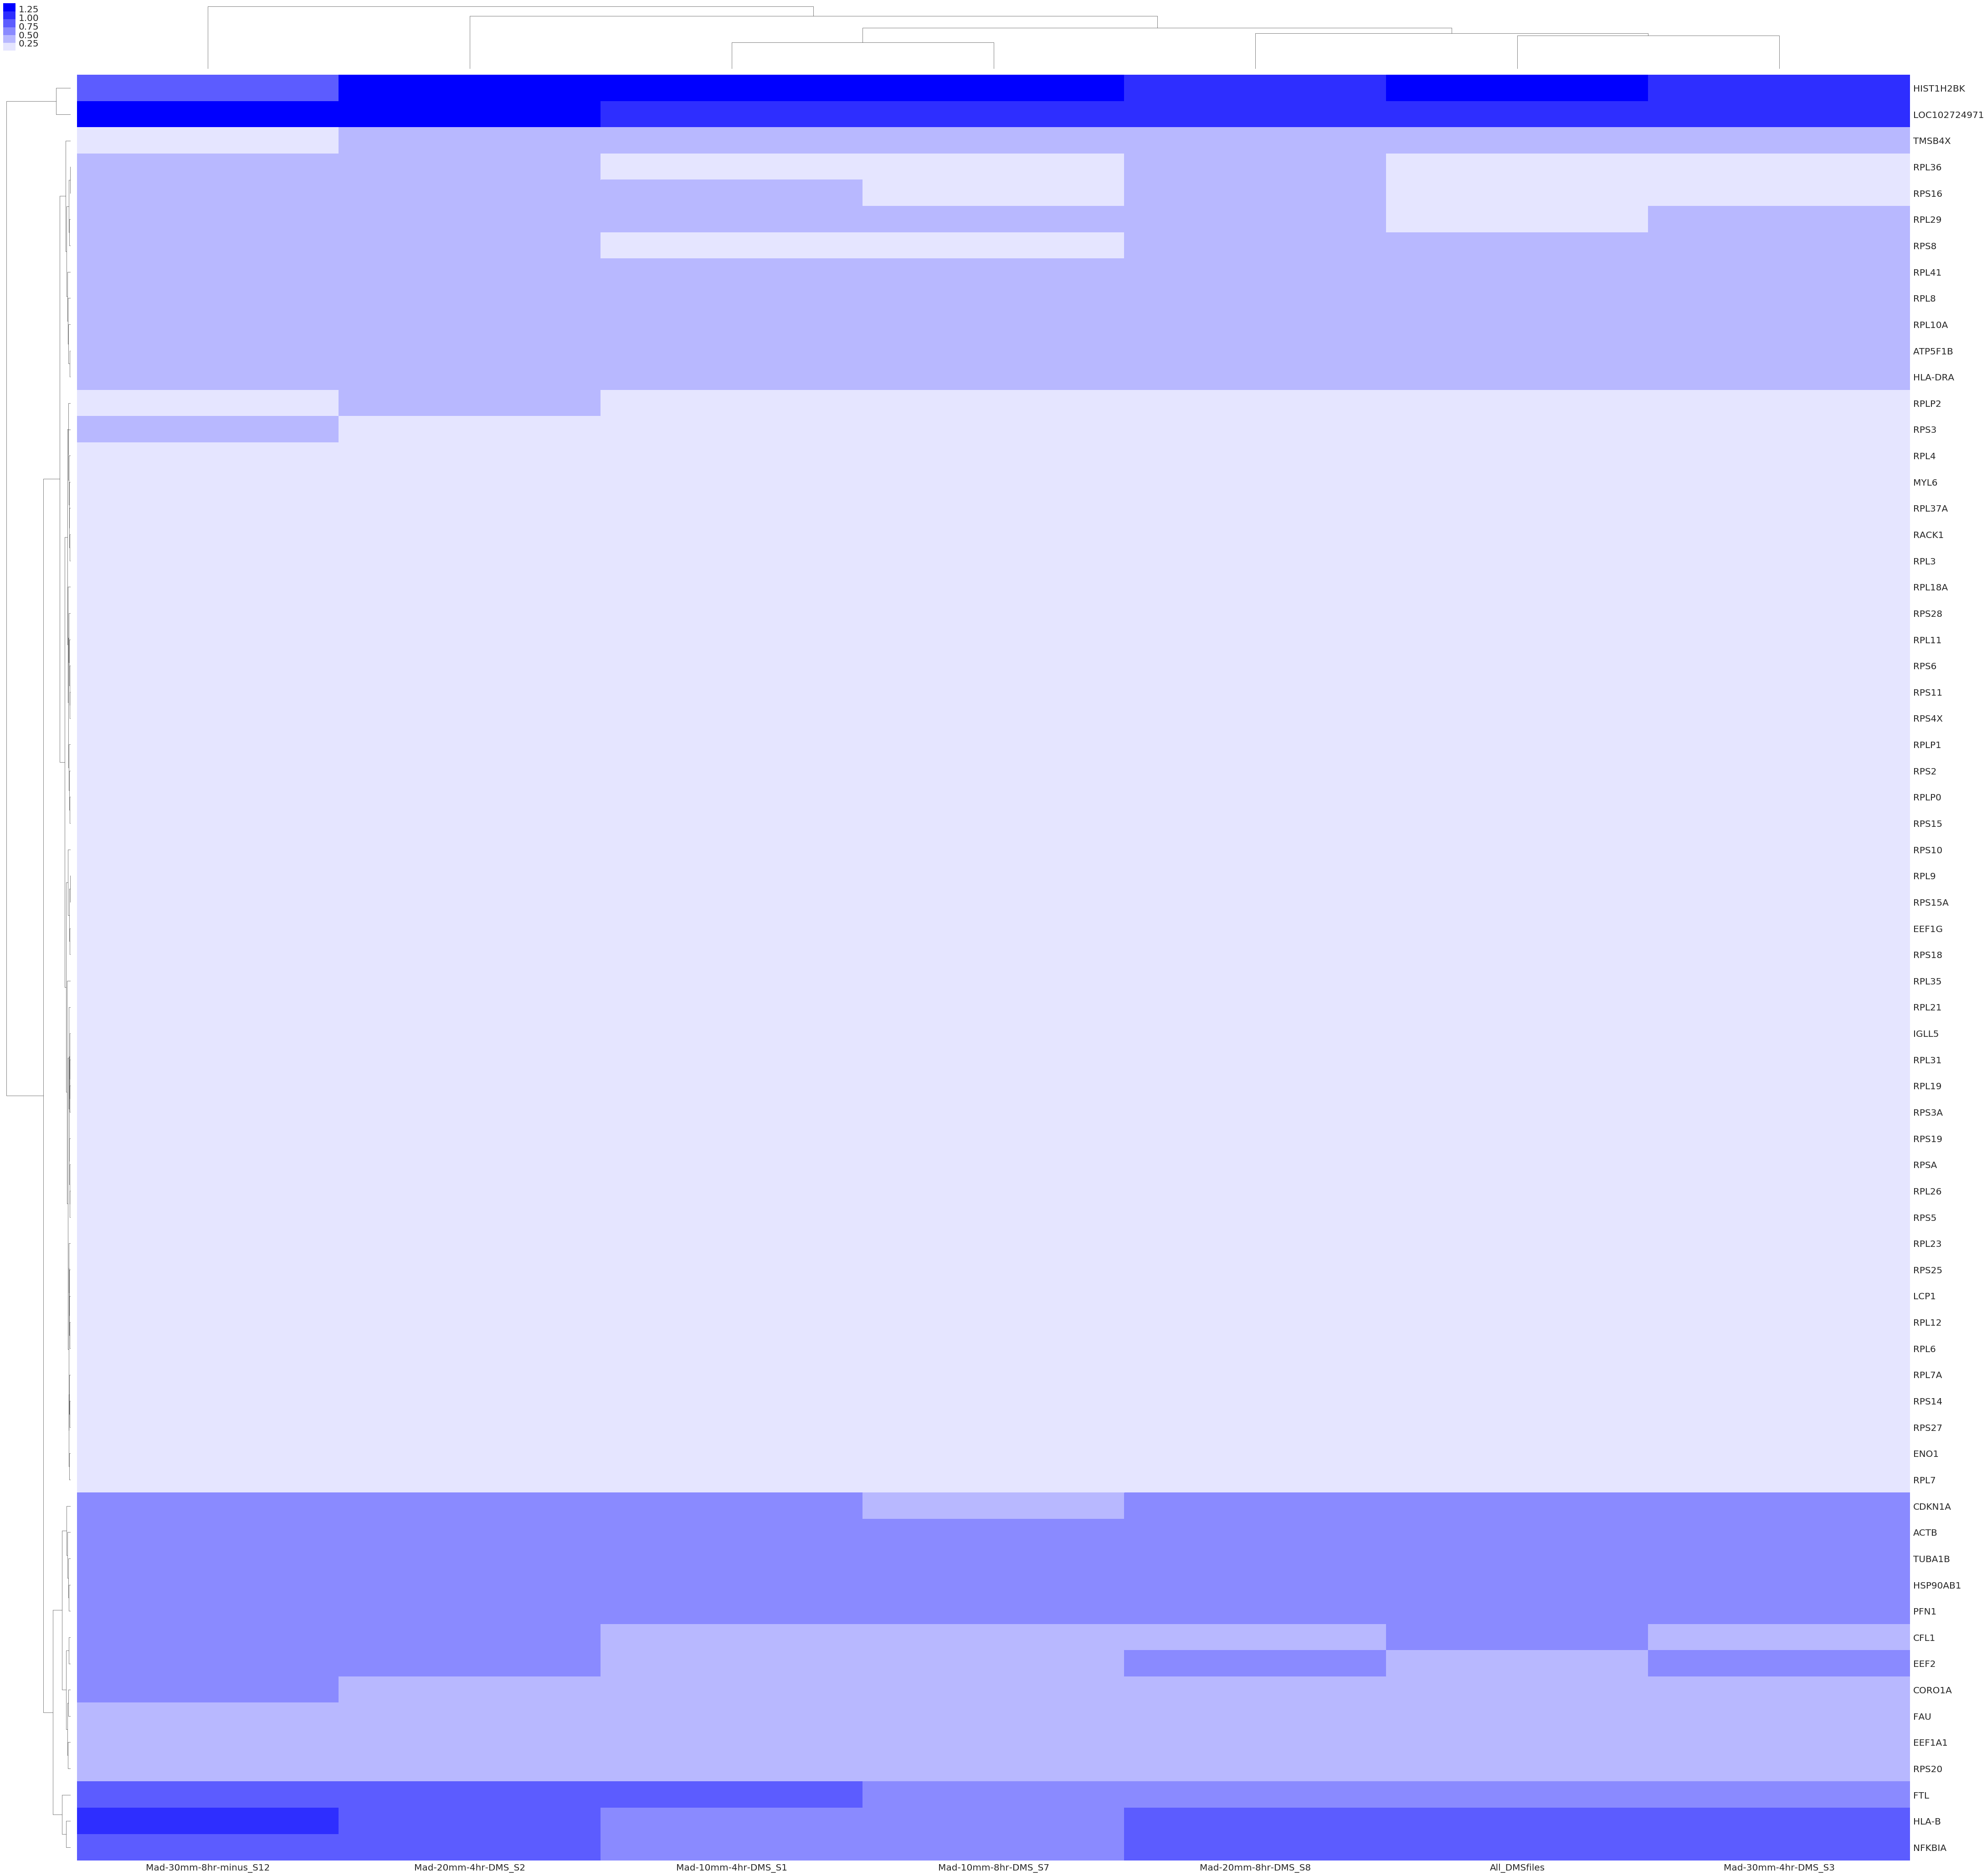

In [17]:
sns.set(font_scale=2)
ax = sns.clustermap(ratios_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/Ratio_TranscriptomeVsGenomicReads_PlusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [18]:
labels_indices_org = ratios_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts= ratios_readCounts.reindex(labels_indices_reordered)

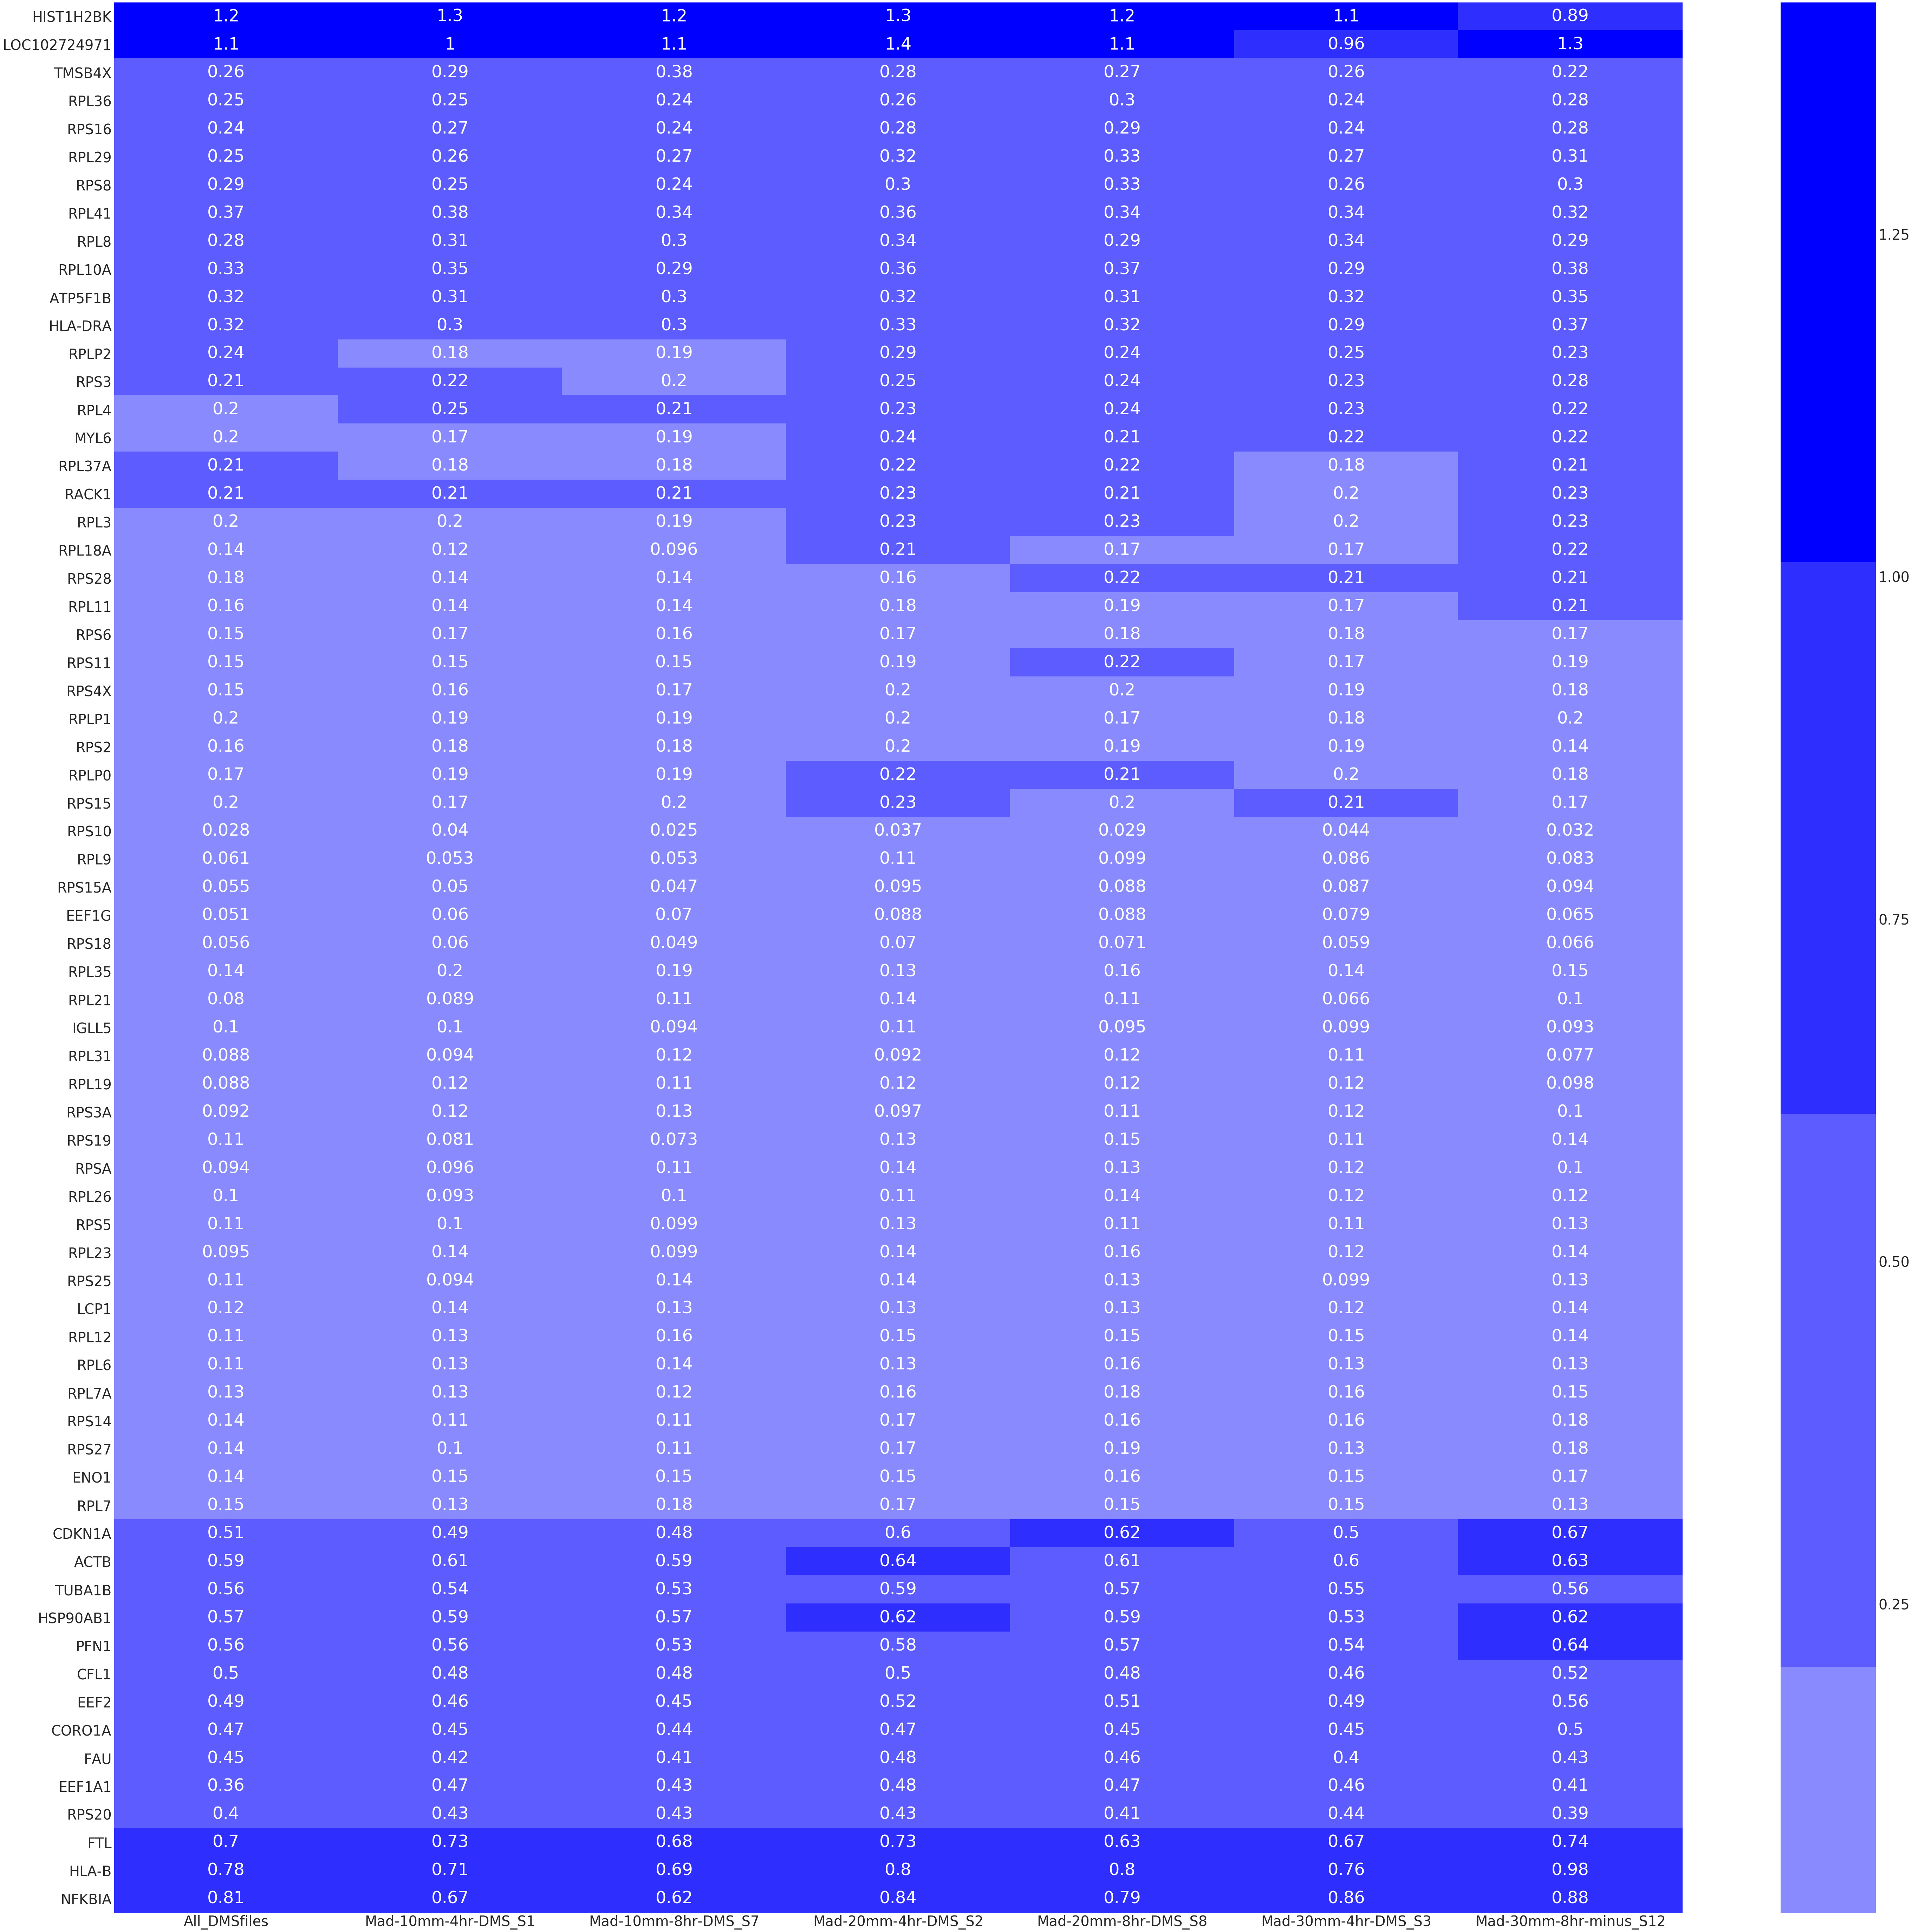

In [20]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratios_readCounts.values, ax=ax,center=0.2)
plt.savefig("../results/Ratio_TranscriptomeVsGenomicReads_PlusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")